In [1]:
# Python 3.8.5

# Визуализация данных с помощью Seaborn

Цель задания - исследование датасета dataset_file_storage.csv и визуализация данных с помощью Seaborn.

Для каждой задачи необходимо:

- Построить график-гистограмму (размер графика должен быть достаточным для визуального анализа).

- Подписать оси и заголовок.

- Ответить на поставленные вопросы.
___________

- Код должен выполняться при условии наличия датасета в каталоге со скриптом или указанием пути к датасету (падение кода с ошибкой у проверяющего на python аналогичной версии - повод не зачесть все пункты соответствующей задачи).

Описание полей датасета:
- ProjectID (число) - id проекта в рамках которого загружен файл, привязка к элементам другой таблицы
- UserID (число) - id пользователя, загрузившего файл, привязка к элементам другой таблицы
- uploadServerUnixTime (число) - время загрузки файла на сервер в формате UnixTime
- CompanyID (число) - id организации которой принадлежит пользователь, привязка элемента другой таблицы
- FileSize (число) - размер файла в байтах
- TypeDocs (строка) - раздел в который загружен файл
    
Для общего понимания архитектуры датасета:
Есть организации-застройщики (CompanyID), в каждой из которых может быть несколько пользователей (UserID).
Существуют проекты (ProjectID), к каждому из которых может иметь доступ несколько пользователей разных организаций (пользователь может иметь доступ к нескольким проектам).
Внутри каждого проекта есть несколько разделов (TypeDocs), в который пользователь загружает файлы для организации.

Перед выполнением заданий необходимо импортировать требуемые для работы модули Python, загрузить датасет в датафрейм и выполнить его предварительную обработку:
- очистить датафрейм от неполных данных (есть записи за неполный месяц март);
- преобразовать столбец "uploadServerUnixTime" в пригодный для работы формат с помощь методов модуля datetime;
- на основе столбца "uploadServerUnixTime" добавить необходимые столбцы для группировки данных (месяц, день и т.п

Пожелания при выполнении заданий (они не влияют на итоговую оценку):
- постарайтесь оформить как функцию вывод однотипных графиков и вызывать её в нужных местах;
- для облегчения понимания написанного кода добавлять к нему комментарии.

In [2]:
# импорт модулей и данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Задание №1

### Задание 1.1
Постройте накопительный график/гистограмму суммарного объёма загруженных файлов по дням (используйте логарифмическую шкалу для объёма).

In [3]:
df = pd.read_csv('dataset_file_storage.csv', sep=';')
df_datetime = df['uploadServerUnixTime'].transform(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df.insert(3, 'uploadServerDT', df_datetime)
df['uploadServerDT'] = pd.to_datetime(df['uploadServerDT'])

In [4]:
# убираем записи за март

df = df.drop(df[df['uploadServerDT'].dt.month == 3].index, axis=0)

In [5]:
# добавляем новые признаки времени
df['day'] = df['uploadServerDT'].dt.day
df['month'] = df['uploadServerDT'].dt.month
df['hour'] = df['uploadServerDT'].dt.hour
df['weekday'] = df['uploadServerDT'].dt.weekday
df['weekday'] = df['weekday'].replace({0: 'Понедельник', 1: 'Вторник', 
                                       2: 'Среда', 3: 'Четверг', 4: 'Пятница', 
                                       5: 'Суббота', 6: 'Воскресенье'})
df['PartOfDay'] = df['uploadServerDT'].transform(lambda x: 'Первая' if x.hour < 13
                                                 else 'Вторая')
df.head()

,ProjectID,UserID,uploadServerUnixTime,uploadServerDT,CompanyID,FileSize,TypeDocs,day,month,hour,weekday,PartOfDay
0,753919,27549,1582272443,2020-02-21 08:07:23,753918,732686,6.Юридические документы,21,2,8,Пятница,Первая
1,726628,26990,1582216416,2020-02-20 16:33:36,726615,2484373,8.Другие документы,20,2,16,Четверг,Вторая
2,705607,26912,1571732077,2019-10-22 08:14:37,703124,22,1.Основные документы,22,10,8,Вторник,Первая
3,705605,26912,1571048621,2019-10-14 10:23:41,703124,4,1.Основные документы,14,10,10,Понедельник,Первая
4,705605,26912,1570799210,2019-10-11 13:06:50,703124,1030735,1.Основные документы,11,10,13,Пятница,Вторая


In [6]:
df['hour'].unique()

array([ 8, 16, 10, 13,  7,  9, 11,  5,  6, 12, 14, 18, 15,  4, 17, 21, 19],
      dtype=int64)

In [7]:
# считаем накопленный объем файлов
cumul_by_date = df.groupby(by=df['uploadServerDT'].dt.date).FileSize.sum().cumsum()
cumul_by_date.head()

uploadServerDT
2019-10-10    239262494
2019-10-11    241323968
2019-10-14    241323980
2019-10-15    243590983
2019-10-16    243590987
Name: FileSize, dtype: int64

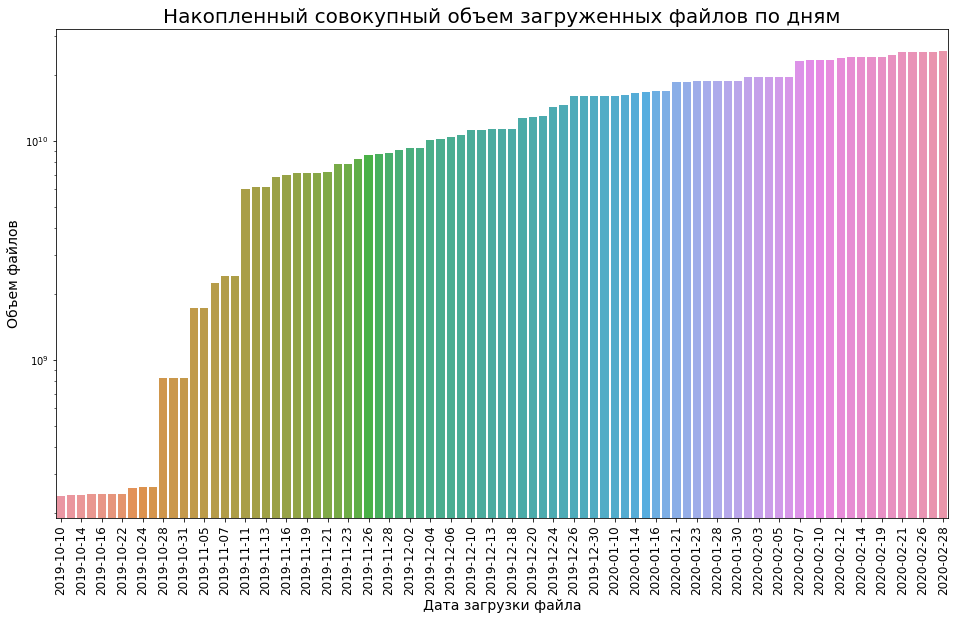

In [8]:
plt.figure(figsize=(16, 9))
sns.barplot(x=cumul_by_date.index, y=cumul_by_date.values)
plt.yscale('log')
plt.xticks(ticks=range(0, cumul_by_date.shape[0], 2), labels=cumul_by_date.index[::2], rotation=90, fontsize=12)
plt.title('Накопленный совокупный объем загруженных файлов по дням', fontsize=20)
plt.xlabel('Дата загрузки файла', fontsize=14)
plt.ylabel('Объем файлов', fontsize=14)
plt.show()

### Задание 1.2
Какой прогноз можно дать по объему файлового хранилища на конец 2020?

Объем файлового хранилища будет увеличиваться. Для того, чтобы определить характер возрастания объема загружаемых файлов, построим график накопленного объема загруженных файлов помесячно. 

In [9]:
cumul_by_month = df.groupby(pd.Grouper(key='uploadServerDT', freq='M'))['FileSize'].sum().cumsum()

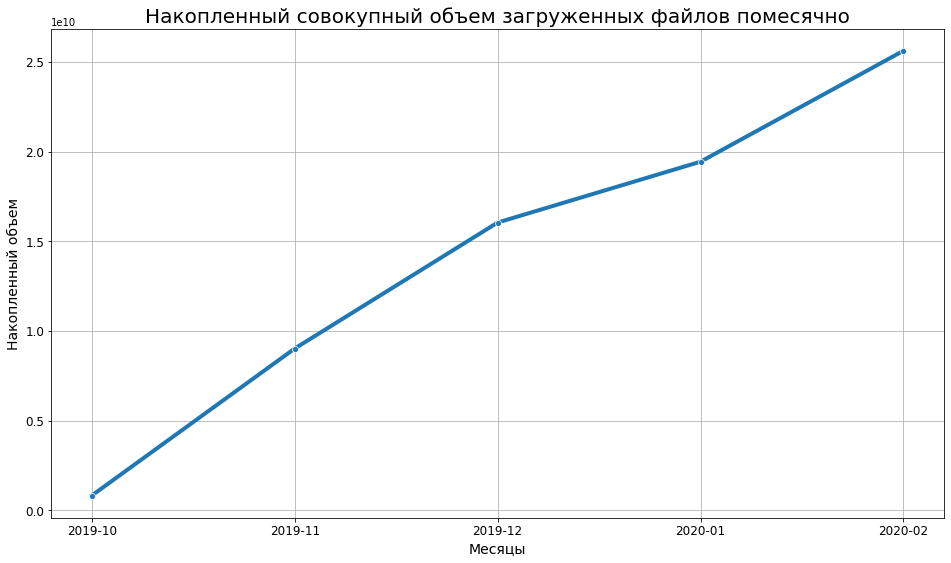

In [10]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=cumul_by_month, x=cumul_by_month.index.strftime('%Y-%m'), marker='o', lw=4)
plt.title('Накопленный совокупный объем загруженных файлов помесячно', fontsize=20)
plt.ylabel('Накопленный объем', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.grid()
plt.tick_params(labelsize=12)

Можно заметить, что в каждый месяц совокупный объем загруженных файлов увеличивается примерно на одну и ту же величину, т. е. увеличивается линейно. Именно поэтому принято решение о построении прогноза на основе приближения к линейной функции.

In [11]:
cumul_by_month_ext = cumul_by_month.append(pd.Series(index=pd.date_range(start='2020-03-01', end='2021-01-01', 
                                                                     freq='M'), data=np.nan))
cumul_by_month_ext = cumul_by_month_ext.interpolate(method='spline', order=1)
cumul_by_month_ext.tail()

C:\Users\Dasha\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


2020-08-31    6.483000e+10
2020-09-30    7.122405e+10
2020-10-31    7.783124e+10
2020-11-30    8.422529e+10
2020-12-31    9.083247e+10
Freq: M, dtype: float64

### Задание 1.3
На основании прогноза постройте накопительный график/гистограмму суммарного объёма загруженных файлов помесячно: первые месяцы будут реальные данные, а далее, начиная с марта - прогнозируемый объем. (Подсказка: для более точного прогноза месячного прироста суммарного объема файлов исключите из анализа месяцы с неполными данными.)

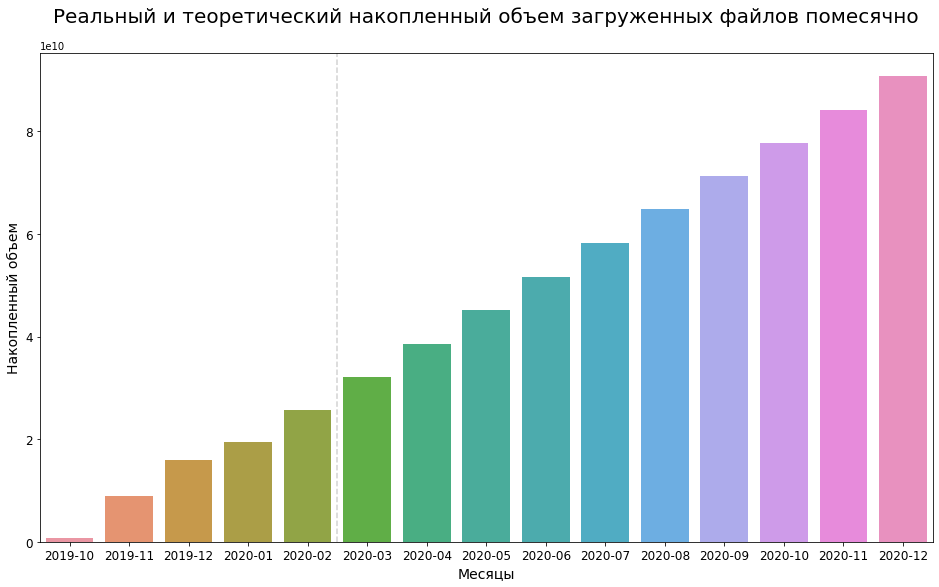

In [12]:
plt.figure(figsize=(16, 9))
sns.barplot(x=cumul_by_month_ext.index.strftime('%Y-%m'), y=cumul_by_month_ext)
plt.title('Реальный и теоретический накопленный объем загруженных файлов помесячно', fontsize=20, y=1.05)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Накопленный объем', fontsize=14)
plt.axvline(4.5, color='lightgray', ls='--')
plt.tick_params(labelsize=12)

Таким образом, на конец 2020 года накопленный объем загруженных файлов составит около **85 гигабайт**.

## Задание №2
Постройте 2 гистограммы:
-	Распределения количества файлов по дням недели
-	Распределения количества файлов по часам

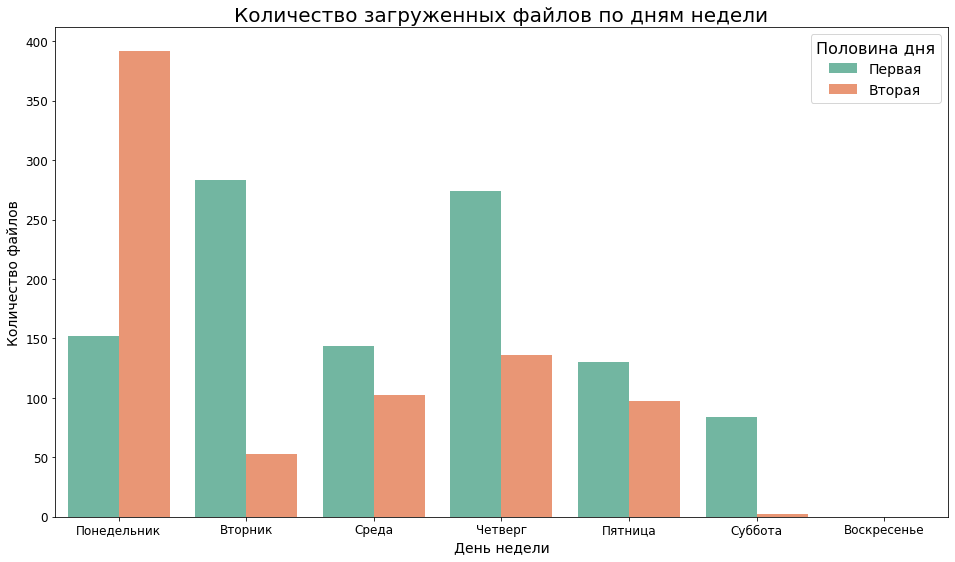

In [13]:
plt.figure(figsize=(16, 9))
sns.countplot(data=df, x='weekday', hue='PartOfDay', order=['Понедельник', 'Вторник', 'Среда', 
                                           'Четверг', 'Пятница', 'Суббота', 'Воскресенье'], palette='Set2')
plt.title('Количество загруженных файлов по дням недели', fontsize=20)
plt.ylabel('Количество файлов', fontsize=14)
plt.xlabel('День недели', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(title='Половина дня', fontsize=14, loc='upper right', title_fontsize=16)

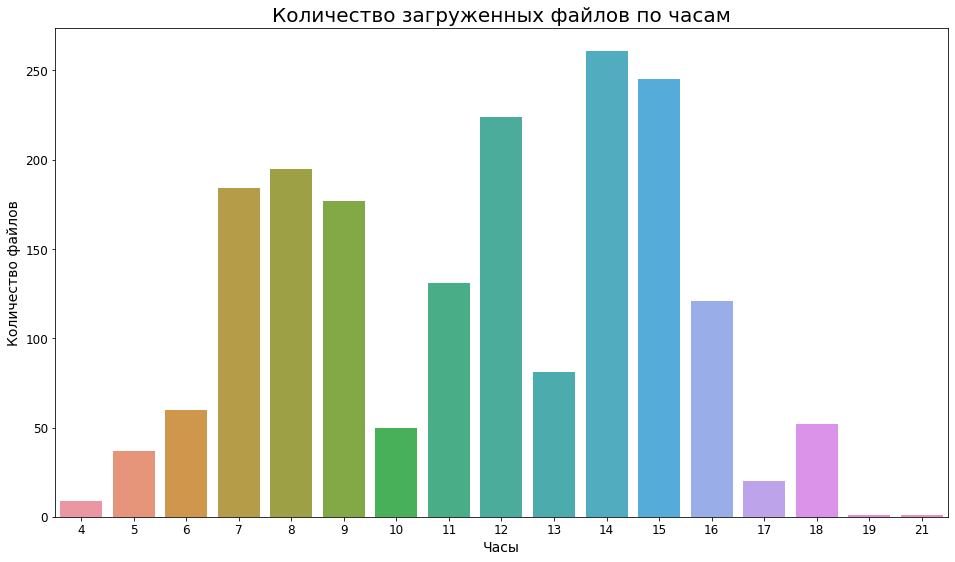

In [14]:
plt.figure(figsize=(16, 9))
sns.countplot(data=df, x='hour')
plt.title('Количество загруженных файлов по часам', fontsize=20)
plt.xlabel('Часы', fontsize=14)
plt.ylabel('Количество файлов', fontsize=14)
plt.tick_params(labelsize=12)

### Задание 2.1 (дополнительное для отличников)
На основании построенных гистограмм какие выводы можно сделать?

На основании построенных графиков можно сделать вывод, что б**о**льшая часть файлов, как правило, загружается в понедельник, причем во вторую половину дня. Значительный объем загрузок совершается в четверг и вторник. При этом в четверг основной объем загрузок приходится на вторую половину дня, а во вторник - на первую. 
Примерно одинаковое количество загруженных файлов зафиксировано в среду и пятницу. <br>

На основании первого графика был сделан вывод, что в основном во все дни загрузки совершаются во вторую половину дня (до 13:00), что также и подтверждается результатами второго графика. Заметим, что б**о**льшая часть загрузок совершается в 15, 17 и 18 часов. 
В первой половине дня файлы загружаются, как правило, в период с 10 до 13 часов. 

## Задание №3
Постройте 2 гистограммы:
- Распределения количества файлов в зависимости от раздела.
- Постройте ящики с усами для среднего количества файлов в проекте в зависимости от раздела.

Text(0.5, 1.02, 'Распределение загруженных файлов по разделам')

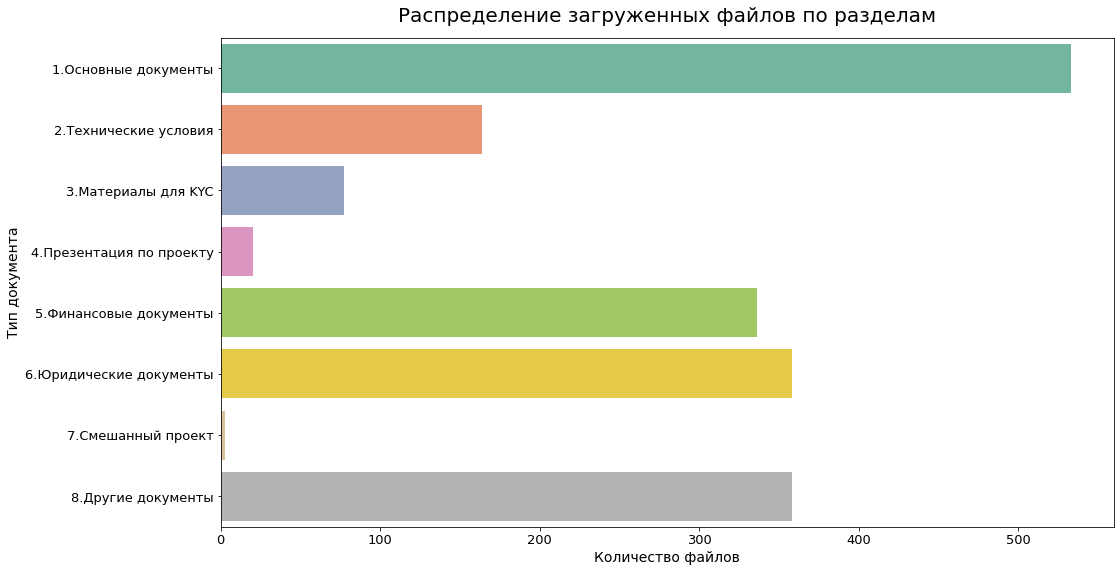

In [15]:
plt.figure(figsize=(16, 9))
sns.countplot(data=df, y='TypeDocs', order=['1.Основные документы', "2.Технические условия", 
                                           "3.Материалы для KYC", "4.Презентация по проекту",
                                           "5.Финансовые документы", "6.Юридические документы", 
                                           "7.Cмешанный проект", "8.Другие документы"],  palette='Set2')
plt.ylabel('Тип документа', fontsize=14)
plt.xlabel('Количество файлов', fontsize=14)
plt.tick_params(labelsize=13)
plt.title('Распределение загруженных файлов по разделам', fontsize=20, y=1.02,)

In [16]:
# P.S. График отражает распределение количества файлов в проекте в каждом из разделов
# из задания не совсем понятно, что конкретно нужно отобразить

qty = df.groupby(['TypeDocs', 'ProjectID'])['UserID'].count()
qty = qty.reset_index()
qty = qty.rename({'UserID': 'FileQuantity'}, axis=1)

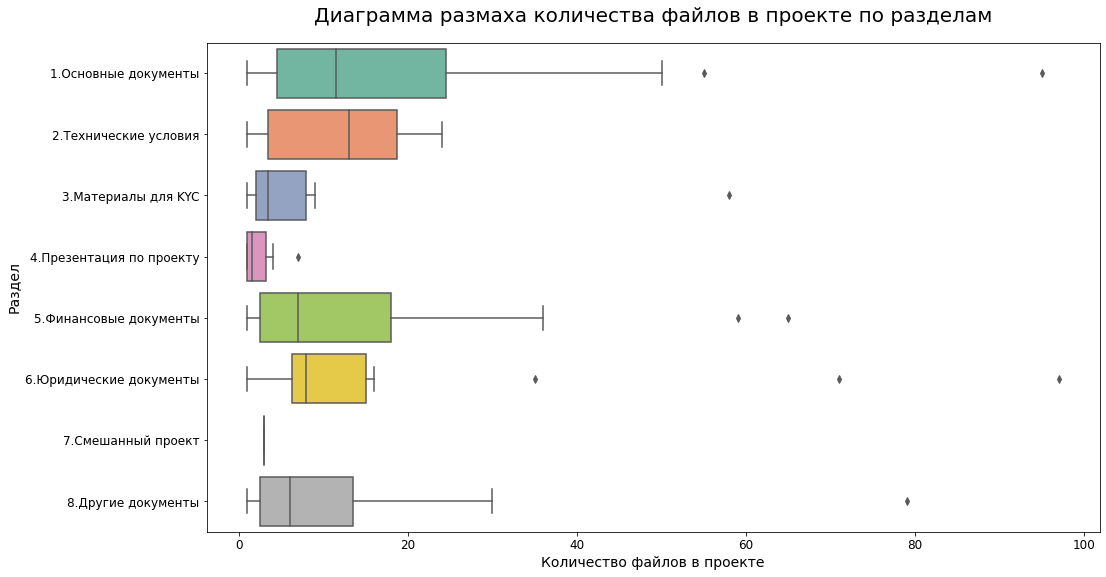

In [17]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=qty, y='TypeDocs', x='FileQuantity', palette='Set2')
# plt.xscale('log')
plt.xlabel('Количество файлов в проекте', fontsize=14)
plt.ylabel('Раздел', fontsize=14)
plt.title('Диаграмма размаха количества файлов в проекте по разделам', fontsize=20, y=1.03)
plt.tick_params(labelsize=12)

### Задание 3.1 (дополнительное для отличников)
Какие рекомендации можно дать по создания/удалению разделов?

Возможно, стоит расформировать разделы "Основные документы" и "Другие документы" на несколько подразделов. 

## Задание №4
Постройте гистограмму суммарного объёма файлов по проектам (используйте логарифмическую шкалу для объёма).

In [18]:
fs_proj = df.groupby('ProjectID')['FileSize'].sum().sort_values(ascending=False).reset_index()

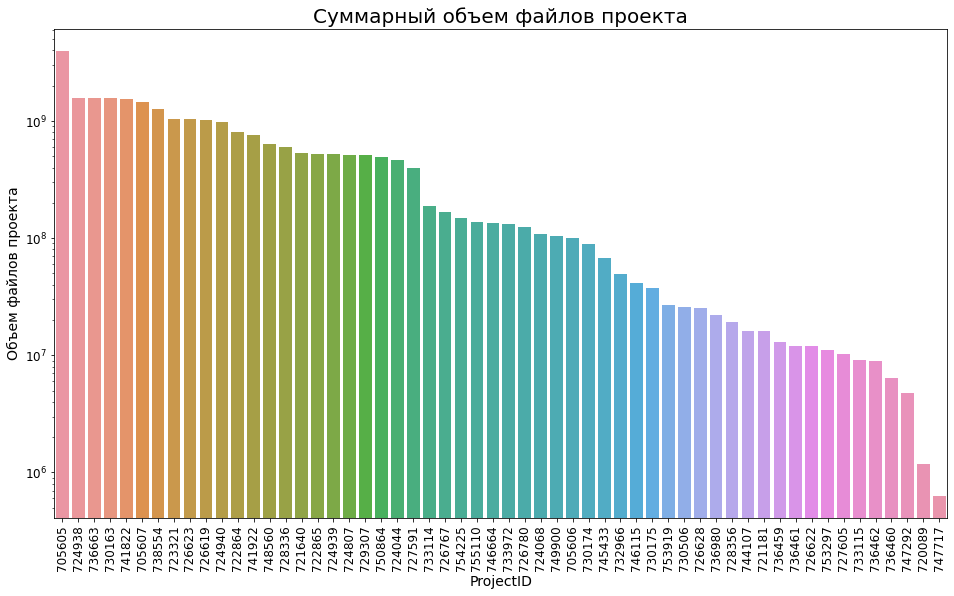

In [19]:
plt.figure(figsize=(16, 9))
sns.barplot(data=fs_proj, x='ProjectID', y='FileSize', order=fs_proj['ProjectID'])
plt.xlabel('ProjectID', fontsize=14)
plt.ylabel('Объем файлов проекта', fontsize=14)
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.yscale('log')
plt.title('Суммарный объем файлов проектa', fontsize=20)

plt.show()

## Задание №5
Постройте ящики с усами для размеров загружаемых файлов по компаниям.

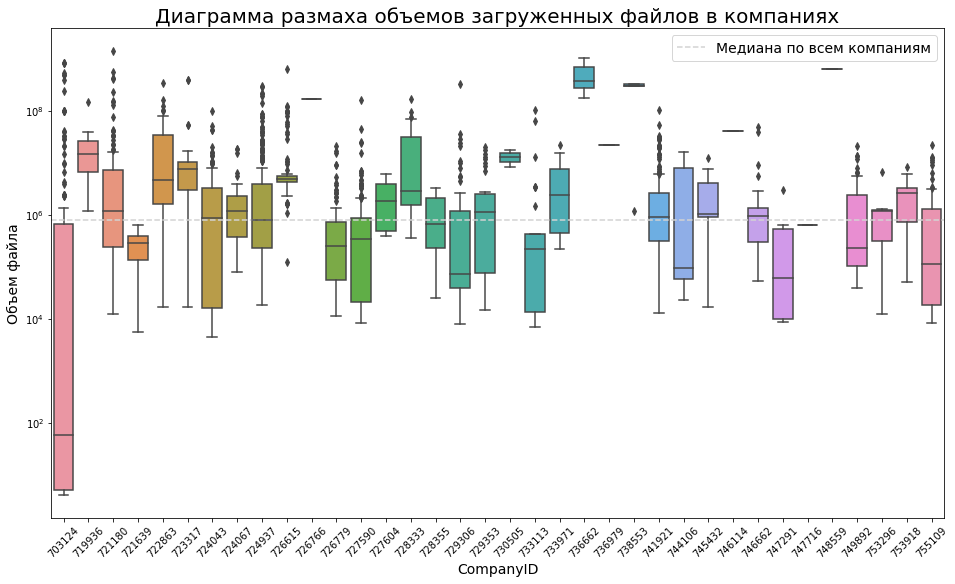

In [20]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=df, x='CompanyID', y='FileSize')
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('CompanyID', fontsize=14)
plt.ylabel('Объем файла', fontsize=14)
plt.title('Диаграмма размаха объемов загруженных файлов в компаниях', fontsize=20)
plt.axhline(df['FileSize'].median(), color='lightgray', ls='--', label='Медиана по всем компаниям')
plt.legend(fontsize=14)
plt.show()

### Задание 5.1 (дополнительное для отличников)
Можно ли сделать какие-то выводы о предпочтениях к большим/маленьким файлам в разных компаниях? Можно ли сделать практически полезные выводы для администраторов сервиса загрузки?

* Можно заметить, что пользователи компании под номером **736662** загружают файлы только больших объемов. 

* Пользователи компаний **726615, 730505** также преимущественно загружают файлы, объемы которых значительно превышают медианный уровень по всем компаниям.

* Пользователи компании **703124**, напротив, загружают файлы меньших размеров. 

## Задание №6
Какие ещё графики вы построили для этих данных и какой вывод из этой иллюстрации можно сделать? Постройте ещё хотя бы 1 любой график/гистограмму/боксплот или иную иллюстрацию.

Построим график, отражающий средний объем загружаемых файлов в расчете на 1 проект в каждой из компаний. 

In [21]:
fs_per_proj = df.groupby('CompanyID').apply(lambda x: x['FileSize'].sum() / x['ProjectID'].count()).reset_index()
fs_per_proj = fs_per_proj.rename({0: 'MeanFileSizePerProj'}, axis=1).sort_values('MeanFileSizePerProj', ascending=False)

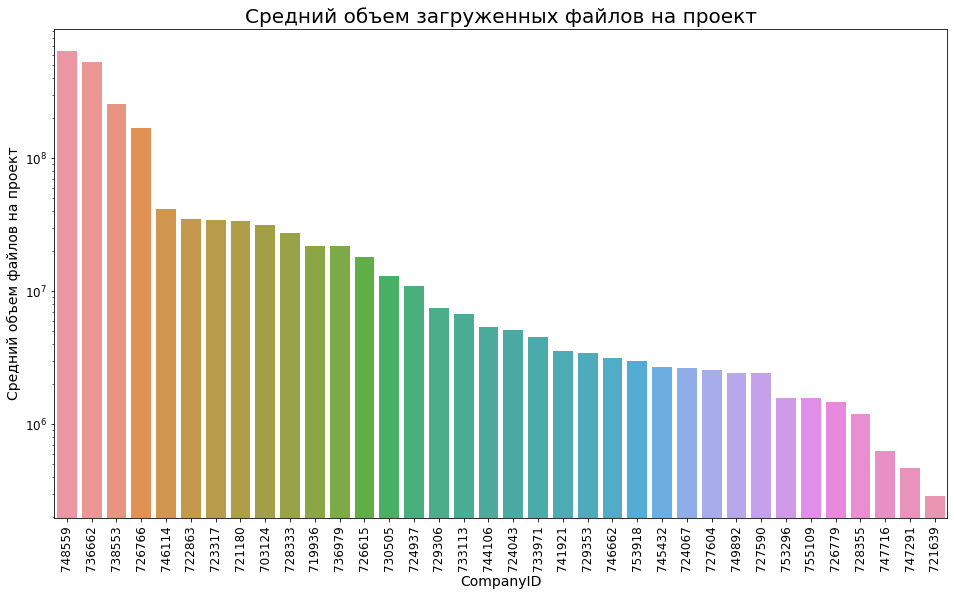

In [22]:
plt.figure(figsize=(16, 9))
sns.barplot(data=fs_per_proj, x='CompanyID', y='MeanFileSizePerProj', order=fs_per_proj['CompanyID'])
plt.xticks(rotation=90)
plt.title('Средний объем загруженных файлов на проект', fontsize=20)
plt.xlabel('CompanyID', fontsize=14)
plt.ylabel('Cредний объем файлов на проект', fontsize=14)
plt.yscale('log')
plt.tick_params(labelsize=12)
plt.show()